# TP1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 8th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [3]:
# Change here using YOUR first and last names
fn1 = "yu"
ln1 = "li"
fn2 = "yanlin"
ln2 = "du"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_li_yu_and_du_yanlin.ipynb


In [4]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

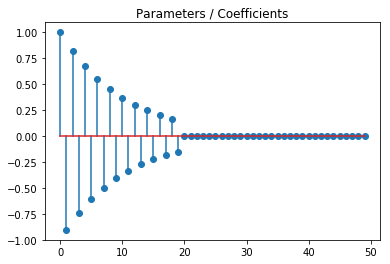

In [6]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [7]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [8]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    x = x-(x>s*t)*s*t + (x<-s*t)*s*t - (x<=t*s)*(x>=-t*s)*x
    return x 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    temp = np.linalg.norm(x,1)
    val = s*temp
    return val

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    x = 1.0/(1+t*s)*x
    return x 
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    temp = np.linalg.norm(x,2)**2
    val = (s/2.0)*temp
    return val

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

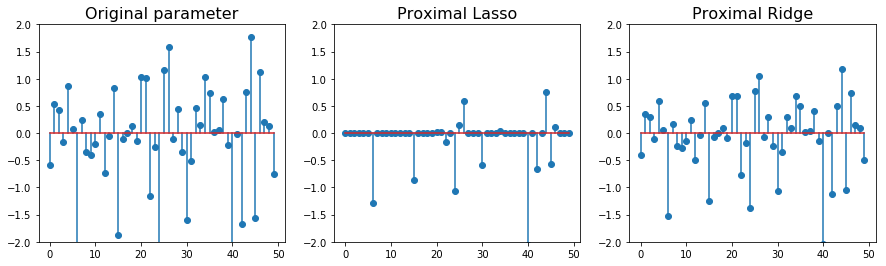

In [9]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

## ANSWER

- For Lasso, most of the parameters become 0. We get a sparse matrix.
- For ridge, the grapgh of the proximal ridge and the original parameter are similar and the values of points in proximal ridge are proportional to those in the graph of original parameter. Il shrinks the value of the coeffients but doesn't reach to 0.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [10]:
def loss_linreg(x):
    """Least-squares loss"""
    
    n = np.shape(A)[0]
    temp = b - A.dot(x)
    val_linreg = (1./(2*n))*np.linalg.norm(temp,2)**2
    return val_linreg
    

def grad_linreg(x):
    """Least-squares gradient"""
    
    n = np.shape(A)[0]
    grad_linreg = (1./n)*A.T.dot(A.dot(x)- b)
    return grad_linreg

def loss_logreg(x):
    """Logistic loss"""
    
    val_logreg=0
    temp = 0
    n = np.shape(A)[0]
    for i in range(n):
        temp+=np.log(1+np.exp(-b[i]*A[i].T.dot(x)))
    val_logreg = temp/n
    
    return val_logreg

def grad_logreg(x):
    """Logistic gradient"""
    
    n = np.shape(A)[0]
    grad_logreg = np.zeros(len(x))
    temp = 0
    for i in range(n):
        temp = np.exp(-b[i]*A[i].T.dot(x))
        grad_logreg += ((-b[i]*A[i].T)*temp)/(1+temp)
    grad_logreg/=n    
    return grad_logreg


In [11]:
from scipy.optimize import check_grad
A, b = simu_logreg(coefs)
print(loss_logreg(x))
print(grad_logreg(x))
check_grad(loss_logreg,grad_logreg,x)

2.97319422681
[-0.13  0.06 -0.02  0.05 -0.05 -0.04 -0.18 -0.04 -0.12 -0.07 -0.07 -0.
 -0.06 -0.03 -0.05 -0.11 -0.09 -0.02  0.01  0.08  0.08  0.04 -0.06 -0.08
 -0.13  0.01  0.11  0.05 -0.   -0.03 -0.09 -0.05  0.01  0.03  0.09  0.05
  0.01  0.01 -0.01 -0.09 -0.21 -0.14 -0.11  0.    0.08  0.02  0.05  0.05
  0.04 -0.04]


3.824999985424461e-06

In [12]:
from scipy.optimize import check_grad
A, b = simu_linreg(coefs)
print(loss_linreg(x))
print(grad_linreg(x))
check_grad(loss_linreg,grad_linreg,x)

21.7959039965
[-0.69  0.47  0.29  0.44  0.23 -0.72 -2.04 -0.87 -0.98 -0.55 -0.56  0.34
 -0.41 -0.12 -0.15 -1.49 -1.1  -0.27 -0.06  0.51  1.34  0.98 -0.39 -1.03
 -1.63  0.96  1.56  0.8   0.25 -0.58 -1.51 -0.94  0.09  1.    1.55  1.51
  0.74  0.44 -0.23 -1.56 -2.96 -1.72 -1.35  0.5   1.1  -0.46  0.74  0.27
  0.15 -0.43]


2.9538590222068603e-06

## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

**Answer**

- To get the Lipschitz constant for linear regression losses, as we have proved in the class, $L=\frac{\sigma_{max}^{2}(A)}{n}$.
- To get the Lipschitz constant for logistic regression losses, as we learned from the class, $L=\sum_{i=1}^n\frac{{b}_{i}^{2}||{a}_{i}||_{2}^{2}}{n} $, where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$. Therefore ${b}_{i}^{2}$ is always equal to 1. Then we can get $L= \frac{||{A}||_{2}^{2}}{n}$.

In [13]:
from numpy.linalg import norm

In [14]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    n = np.shape(A)[0]
    u,s,v = np.linalg.svd(A)
    lip_linreg = (s[0]**2)/n 
    return lip_linreg
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    
    n = np.shape(A)[0]
    lip_logreg = np.linalg.norm(A,2)**2
    lip_logreg /= n        
    return lip_logreg
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g((x-step*grad_f(x)),s,step)
        x = x_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [15]:
# just to check the value of Lipschitz constant
A, b = simu_linreg(coefs)
print(lip_linreg(A))
A, b = simu_logreg(coefs)
print(lip_logreg(A))

3.19182394327
3.12226719006


In [16]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step*grad_f(z),s,step)
        t_new = (1. + np.sqrt(1+4*t**2))/2.
        z = x_new + (t-1.)/t_new*(x_new-x)
        x = x_new
        t = t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [17]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2
A, b = simu_linreg(coefs)
step = 1./lip_linreg(A)
x, objectives, errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                             s, step,n_iter=n_iter)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.42e+00 | 9.97e-01
      10 | 1.33e+00 | 9.64e-01
      20 | 1.26e+00 | 9.33e-01
      30 | 1.20e+00 | 9.06e-01
      40 | 1.15e+00 | 8.81e-01


In [18]:
x, objectives, errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                              s, step,n_iter=n_iter)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.42e+00 | 9.97e-01
      10 | 1.24e+00 | 9.26e-01
      20 | 1.04e+00 | 8.05e-01
      30 | 9.29e-01 | 6.73e-01
      40 | 8.89e-01 | 5.62e-01


**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using FISTA with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [18]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2


#define the step in algorithm and it equals to 1/L
#compute the precise minimum and minimizer using FISTA after 1000 iterations
A, b = simu_linreg(coefs, n_samples, corr=0.5)
step = 1./lip_linreg(A)
#algorithm fista 
x_outf_0,  func_objf_0, func_errf_0 = fista(x0, loss_linreg, grad_linreg, 
                                            ridge, prox_ridge, step, s, n_iter, x_true=coefs, verbose=False)
print("The minimum of the linear regression with ridge penalization using FISTA with 1000 iterations: "),
print(func_objf_0[-1])
print("The minimizer of the linear regression with ridge penalization using FISTA with 1000 ierations: "),
print(x_outf_0)


The minimum of the linear regression with ridge penalization using FISTA with 1000 iterations: 
0.512772076566
The minimizer of the linear regression with ridge penalization using FISTA with 1000 ierations: 
[ 0.97 -0.86  0.76 -0.7   0.69 -0.6   0.49 -0.44  0.45 -0.37  0.36 -0.31
  0.27 -0.22  0.21 -0.21  0.22 -0.26  0.22 -0.15 -0.01  0.01 -0.01  0.02
 -0.02 -0.06 -0.   -0.    0.01  0.01  0.    0.03  0.02 -0.02 -0.01  0.03
 -0.   -0.01  0.03 -0.06  0.05  0.02 -0.03  0.04 -0.06  0.03 -0.08  0.05
 -0.02 -0.03]


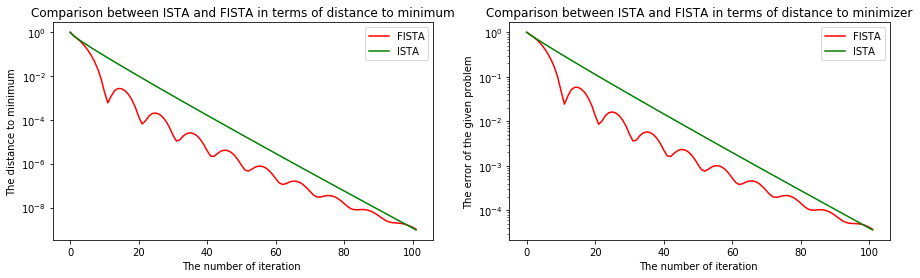

In [19]:
#here we use n_iter=40 and x_true = the precise minimizer that we get with 1000 iterations
#define the step in algorithm and it equals to 1/L

#algorithm fista
x_outf,  func_objf, func_errf = fista(x0, loss_linreg, grad_linreg, 
                                      ridge, prox_ridge, step, s, 100, x_true=x_outf_0, verbose=False)
#alogrithm ista
x_outi,  func_obji, func_erri = ista(x0, loss_linreg, grad_linreg, 
                                     ridge, prox_ridge, step, s, 100, x_true=x_outf_0, verbose=False)


plt.figure(figsize=(15.0, 4.0))
plt.subplot(1,2,1)
#distance to minimum=abs(function value in each iteration-precise minimum)
plt.plot(np.arange(len(func_objf)), abs(func_objf-func_objf_0[-1]),  color='r', label="FISTA")
plt.plot(np.arange(len(func_obji)), abs(func_obji-func_objf_0[-1]),  color='g', label="ISTA")
plt.yscale("log")
plt.title("Comparison between ISTA and FISTA in terms of distance to minimum")
plt.xlabel("The number of iteration ")
plt.ylabel("The distance to minimum")
plt.legend()

plt.subplot(1,2,2)
#here we can directly view the error as the distance to minimizer
plt.plot(np.arange(len(func_errf)), func_errf, color='r', label="FISTA")
plt.plot(np.arange(len(func_erri)), func_erri, color='g', label="ISTA")
plt.yscale("log")
plt.title("Comparison between ISTA and FISTA in terms of distance to minimizer")
plt.xlabel("The number of iteration ")
plt.ylabel("The error of the given problem")
plt.legend()

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

## YOUR ANSWER HERE

### Question 1
Here, in order to study the influence of the correlation of the features on the performance of the algorithm, we change the corr into 5 different values which will change the A and b. To show the performance, we only pay attention to the 4 problems(linear regression+ridge, linear regression+lasso, logistic regression+ridge, logistic+lasso) using FISTA. 

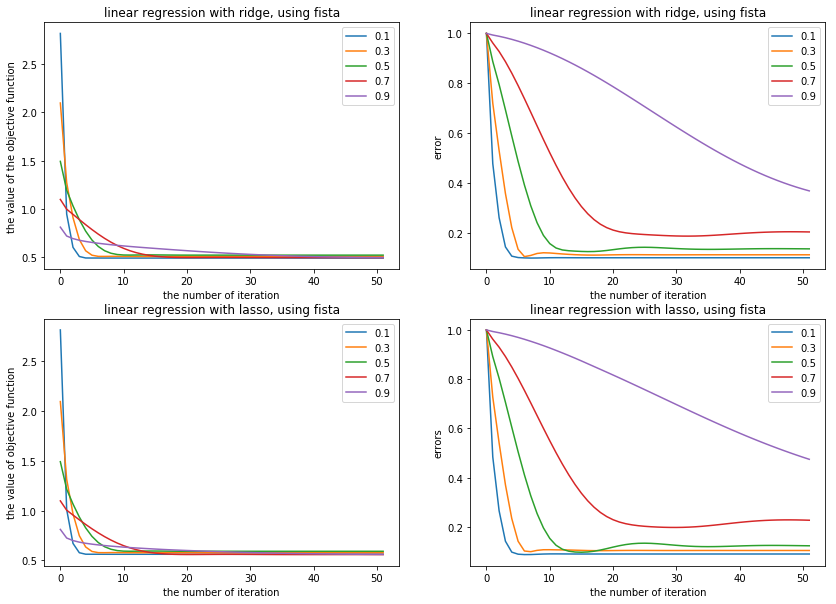

In [22]:
# linear regression
corrs = [0.1,0.3,0.5,0.7,0.9]
plt.figure(figsize=(14.0,10.0))
n_iter=50
s = 1e-2
for corr in corrs:
    
    A,b = simu_linreg(coefs, corr=corr)
    step = 1.0/lip_linreg(A)
    x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                              step, s,n_iter=n_iter,verbose=False)
    
    plt.subplot(2,2,1)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=corr)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with ridge, using fista")
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(n_iter+2),errors_fista,label=corr)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with ridge, using fista")
    
    
    x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, lasso, 
                                                    prox_lasso, step, s,n_iter=n_iter,verbose=False)
    plt.subplot(2,2,3)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=corr)
    plt.legend()
    plt.ylabel("the value of objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using fista")
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(n_iter+2),errors_fista,label=corr)
    plt.legend()
    plt.ylabel("errors")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using fista")
    
    
    

0.603858248654
0.451049340325
0.321736765191
0.175289081072
0.0575195952378


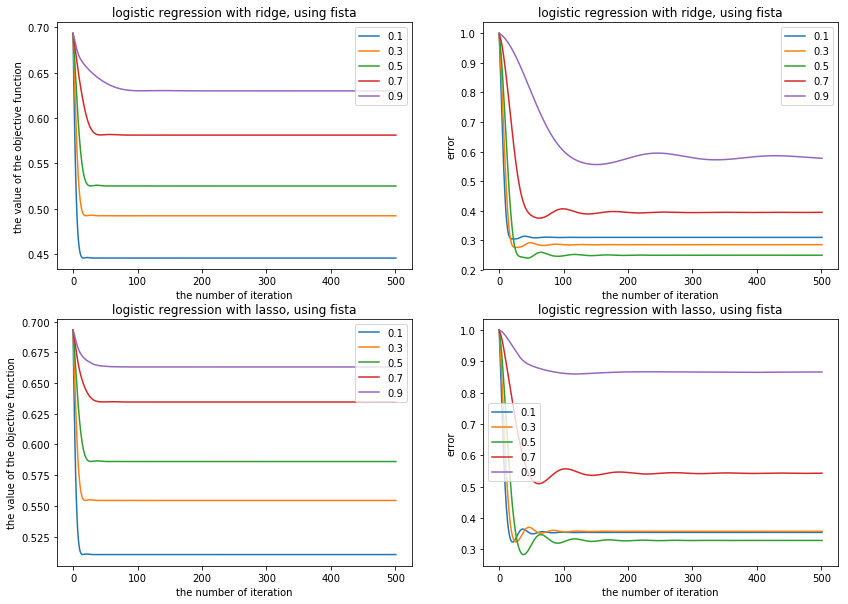

In [23]:
#logistic regression
corrs = [0.1,0.3,0.5,0.7,0.9]
plt.figure(figsize=(14.0,10.0))
n_iter=500
s = 1e-2
for corr in corrs:
    A,b = simu_logreg(coefs, corr=corr)
    step = 1.0/lip_logreg(A)
    x_fista, objectives_fista, errors_fista = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 
                              step, s,n_iter=n_iter,verbose=False)
    
    plt.subplot(2,2,1)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=corr)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with ridge, using fista")
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(n_iter+2),errors_fista,label=corr)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with ridge, using fista")
    
    x_fista, objectives_fista, errors_fista = fista(x0, loss_logreg, grad_logreg, lasso, 
                                                    prox_lasso, step, s,x_true=coefs,n_iter=n_iter,verbose=False)
    plt.subplot(2,2,3)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=corr)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with lasso, using fista")
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(n_iter+2),errors_fista,label=corr)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with lasso, using fista")
    

**Explaination**

From the last 4 figures which show the convergence of fista with different correlation of the features, we can easily conclude that when the features get more and more correlated, the optimisation algorithms converge more slowly and converge to a bigger value . And we can explain this intuitively, if the features are highly correlated, then they provide probably the same information about the target, which makes it more difficult to predict the target. Then the algorithms converge slowly.

### Question 2

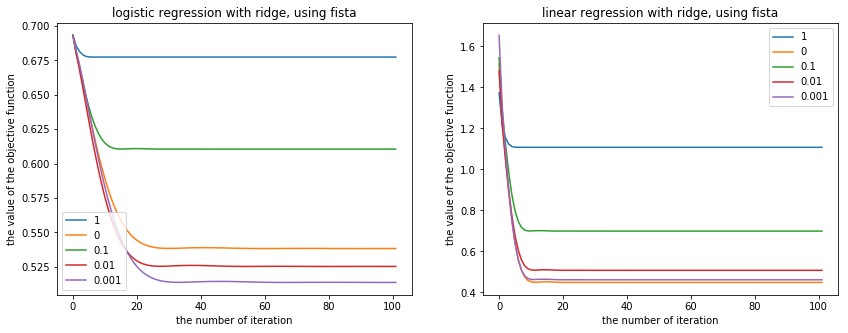

In [229]:
ridge_paras = [1,0,0.1,1e-2,1e-3]
plt.figure(figsize=(14.0,5.0))
n_iter=100

for s in ridge_paras:
    
    A,b = simu_logreg(coefs)
    step = 1.0/lip_logreg(A)
    x_fista, objectives_fista, errors_fista = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 
                              step, s,n_iter=n_iter,verbose=False)
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=s)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with ridge, using fista")
    
    A,b = simu_linreg(coefs)
    step = 1.0/lip_linreg(A)
    x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                              step, s,n_iter=n_iter,verbose=False)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(n_iter+2),objectives_fista,label=s)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with ridge, using fista")
    
    

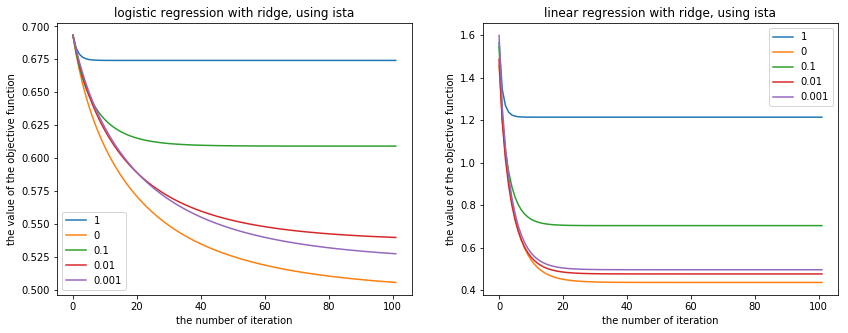

In [230]:
ridge_paras = [1,0,0.1,1e-2,1e-3]
plt.figure(figsize=(14.0,5.0))
n_iter=100

for s in ridge_paras:
    
    A,b = simu_logreg(coefs)
    step = 1.0/lip_logreg(A)
    x_ista, objectives_ista, errors_ista = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 
                              step, s=s,n_iter=n_iter,verbose=False)
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(n_iter+2),objectives_ista,label=s)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("logistic regression with ridge, using ista")
    
    A,b = simu_linreg(coefs)
    step = 1.0/lip_linreg(A)
    x_ista, objectives_ista, errors_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                              step, s,n_iter=n_iter,verbose=False)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(n_iter+2),objectives_ista,label=s)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with ridge, using ista")
    

From the 4 graphes above, we can conclude that as the regularisation parameter decrease, the optimisation algorithms converge more quickly and converge to a smaller value. The regularisation parameter limits the complexity of the model. When this parameter gets smaller, the model can be very complexe and result in overfitting. 

### Question 3

In [105]:
A, b = simu_linreg(coefs, n_samples, corr=0.5)
step = 1./lip_linreg(A)
#Using FISTA to solve the linear regression with ridge penalization
x_outf,  func_objf, func_errf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                                      step, s, n_iter, x_true=coefs, verbose=False)
#Using ISTA to solve the linear regression with ridge penalization
x_outi,  func_obji, func_erri = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 
                                     step, s, n_iter, x_true=coefs, verbose=False)
#Using FISTA to solve the linear regression with lasso penalization
x_outfl,  func_objfl, func_errfl = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, 
                                         step, s, n_iter, x_true=coefs, verbose=False)
#Using ISTA to solve the linear regression with lasso penalization
x_outfil,  func_objfil, func_errfil = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, 
                                           step, s, n_iter, x_true=coefs, verbose=False)


A, b = simu_logreg(coefs, n_samples, corr=0.5)
step = 1./lip_logreg(A)
#Using FISTA to solve the logistic regression with ridge penalization 
x_outfor,  func_objfor, func_errfor = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 
                                            step, s, n_iter, x_true=coefs, verbose=False)
#Using FISTA to solve the logistic regression with lasso penalization 
x_outfla,  func_objfla, func_errfla = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, 
                                            step, s, n_iter, x_true=coefs, verbose=False)
#Using ISTA to solve the logistic regression with ridge penalization 
x_outfior,  func_objfior, func_errfior = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 
                                              step, s, n_iter, x_true=coefs, verbose=False)
#Using ISTA to solve the logistic regression with ridge penalization 
x_outfila,  func_objfila, func_errfila = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, 
                                              step, s, n_iter, x_true=coefs, verbose=False)



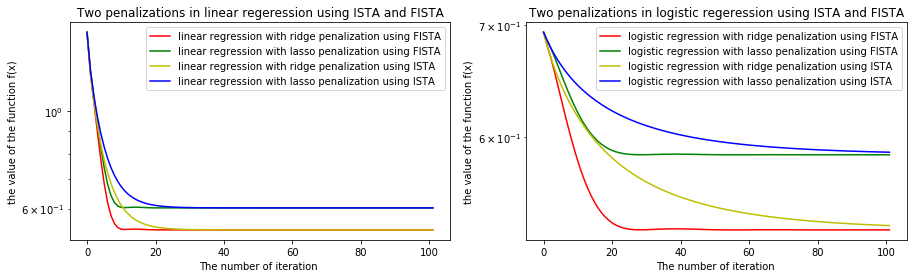

In [107]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1,2,1)
plt.plot(np.arange(len(func_objf)), func_objf, color='r', 
         label="linear regression with ridge penalization using FISTA")
plt.plot(np.arange(len(func_objfl)), func_objfl, color='g', 
         label="linear regression with lasso penalization using FISTA")
plt.plot(np.arange(len(func_obji)), func_obji, color='y', 
         label="linear regression with ridge penalization using ISTA")
plt.plot(np.arange(len(func_objfil)), func_objfil, color='b', 
         label="linear regression with lasso penalization using ISTA")
plt.yscale("log")
plt.title("Two penalizations in linear regeression using ISTA and FISTA")
plt.xlabel("The number of iteration ")
plt.ylabel("the value of the objective function")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(func_objfor)), func_objfor, color='r', 
         label="logistic regression with ridge penalization using FISTA")
plt.plot(np.arange(len(func_objfla)), func_objfla, color='g', 
         label="logistic regression with lasso penalization using FISTA")
plt.plot(np.arange(len(func_objfior)), func_objfior, color='y', 
         label="logistic regression with ridge penalization using ISTA")
plt.plot(np.arange(len(func_objfila)), func_objfila, color='b', 
         label="logistic regression with lasso penalization using ISTA")
plt.yscale("log")
plt.title("Two penalizations in logistic regeression using ISTA and FISTA")
plt.xlabel("The number of iteration ")
plt.ylabel("the value of the objective function")
plt.legend()

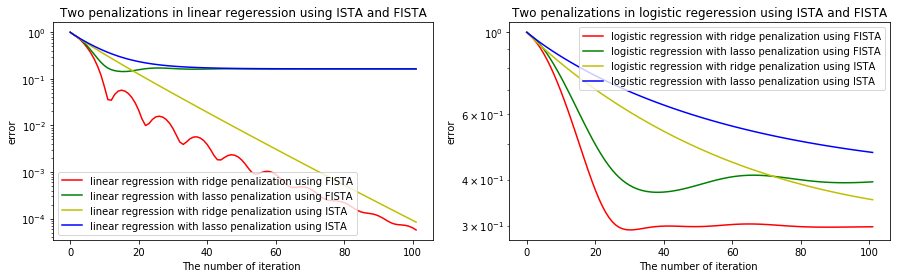

In [231]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1,2,1)
plt.plot(np.arange(len(func_errf)), func_errf, color='r', 
         label="linear regression with ridge penalization using FISTA")
plt.plot(np.arange(len(func_errfl)), func_errfl, color='g', 
         label="linear regression with lasso penalization using FISTA")
plt.plot(np.arange(len(func_erri)), func_erri, color='y', 
         label="linear regression with ridge penalization using ISTA")
plt.plot(np.arange(len(func_errfil)), func_errfil, color='b', 
         label="linear regression with lasso penalization using ISTA")
plt.yscale("log")
plt.title("Two penalizations in linear regeression using ISTA and FISTA")
plt.xlabel("The number of iteration ")
plt.ylabel("error")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(func_errfor)), func_errfor, color='r', 
         label="logistic regression with ridge penalization using FISTA")
plt.plot(np.arange(len(func_errfla)), func_errfla, color='g', 
         label="logistic regression with lasso penalization using FISTA")
plt.plot(np.arange(len(func_errfior)), func_errfior, color='y', 
         label="logistic regression with ridge penalization using ISTA")
plt.plot(np.arange(len(func_errfila)), func_errfila, color='b', 
         label="logistic regression with lasso penalization using ISTA")
plt.yscale("log")
plt.title("Two penalizations in logistic regeression using ISTA and FISTA")
plt.xlabel("The number of iteration ")
plt.ylabel("error")
plt.legend()

**Explaination**

In linear regression and logistic regression, the optimisation algorithm converges quicker with the ridge penalization than that with lasso penalization. Ridge penalization can't zero out coefficients.In contrast, the LASSO does both parameter shrinkage and variable selection automatically. 